# Waves in magnetized Plasmas: O-waves and X-waves

To study electromagnetic waves in a magnetized plasma, in particular polarized either along the applied magnetic fields (O-waves) or perpendicular to it (X-waves) we initialize the simulation with a uniform thermal plasma, effectively injecting waves of all possible wavelengths into the simulation.

The external magnetic field is applied along the `z` direction, and can be controlled through the `Bz0` variable:

In [1]:
import sys  
sys.path.insert(0, '../source')
import em1ds as zpic

electrons = zpic.Species( "electrons", -1.0, ppc = 64, uth=[0.005,0.005,0.005])

sim = zpic.Simulation( nx = 1000, box = 100.0, dt = 0.05, species = electrons )

#Bz0 = 0.5
Bz0 = 1.0
#Bz0 = 4.0

sim.emf.set_ext_fld('uniform', B0= [0.0, 0.0, Bz0])

We run the simulation up to a fixed number of iterations, controlled by the variable `niter`, storing the value of the EM fields $E_y$ (X-wave) and $E_z$ (O-wave) at every timestep so we can analyze them later:

In [2]:
import numpy as np

niter = 1000

Ey_t = np.zeros((niter,sim.nx))
Ez_t = np.zeros((niter,sim.nx))

print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
while sim.n < niter:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    Ey_t[sim.n,:] = sim.emf.Ey
    Ez_t[sim.n,:] = sim.emf.Ez
    sim.iter()

print("\nDone.")


Running simulation up to t = 50 ...
n = 999, t = 49.95
Done.


## EM Waves

As discussed above, the simulation was initialized with a broad spectrum of waves through the thermal noise of the plasma. We can see the noisy fields in the plot below:

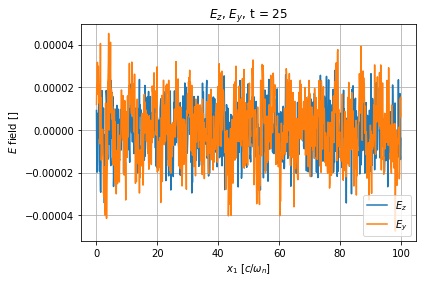

In [3]:
import matplotlib.pyplot as plt

iter = sim.n//2
plt.plot(np.linspace(0, sim.box, num = sim.nx),Ez_t[iter,:], label = "$E_z$")
plt.plot(np.linspace(0, sim.box, num = sim.nx),Ey_t[iter,:], label = "$E_y$")
plt.grid(True)
plt.xlabel("$x_1$ [$c/\omega_n$]")
plt.ylabel("$E$ field []")
plt.title("$E_z$, $E_y$, t = {:g}".format( iter * sim.dt))
plt.legend()
plt.show()

## O-Wave

To analyze the dispersion relation of the O-waves we use a 2D (Fast) Fourier transform of $E_z(x,t)$ field values that we stored during the simulation. The plot below shows the obtained power spectrum, alongside with the theoretical prediction for the dispersion relation (in simulation units):

$\omega = \sqrt{(1 + k^2)}$

Since the dataset is not periodic along $t$ we apply a windowing technique (Hanning) to the dataset to lower the background spectrum, and make the dispersion relation more visible.

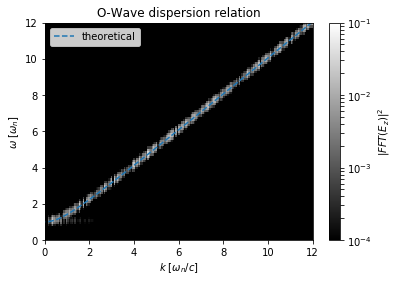

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# (omega,k) power spectrum

win = np.hanning(niter)
for i in range(sim.nx):
    Ez_t[:,i] *= win

sp = np.abs(np.fft.fft2(Ez_t))**2
sp = np.fft.fftshift( sp )

k_max = np.pi / sim.dx
omega_max = np.pi / sim.dt

plt.imshow( sp, origin = 'lower', norm=colors.LogNorm(vmin = 1e-4, vmax = 0.1),
           extent = ( -k_max, k_max, -omega_max, omega_max ),
           aspect = 'auto', cmap = 'gray')

plt.colorbar().set_label('$|FFT(E_z)|^2$')

# Theoretical prediction
k = np.linspace(-k_max, k_max, num = 512)
plt.plot( k, np.sqrt( 1 + k**2), label = "theoretical", ls = "--" )

plt.ylim(0,12)
plt.xlim(0,12)
plt.xlabel("$k$ [$\omega_n/c$]")
plt.ylabel("$\omega$ [$\omega_n$]")
plt.title("O-Wave dispersion relation")
plt.legend()
plt.show()


## X-wave

To analyze the dispersion relation of the O-waves we use a 2D (Fast) Fourier transform of $E_y(x,t)$ field values that we stored during the simulation. The theoretical prediction has 2 branches:

$\omega = 0$

Since the dataset is not periodic along $t$ we apply a windowing technique (Hanning) to the dataset to lower the background spectrum, and make the dispersion relation more visible.

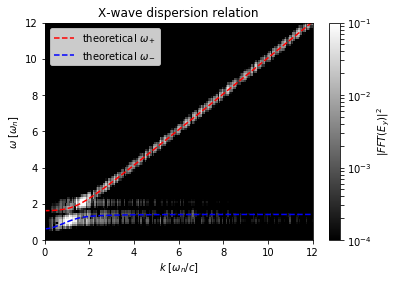

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

win = np.hanning(niter)
for i in range(sim.nx):
    Ey_t[:,i] *= win


k_max     = np.pi / sim.dx
omega_max = np.pi / sim.dt
sp = np.abs( np.fft.fft2(Ey_t))**2 
sp = np.fft.fftshift( sp )

plt.imshow( sp, origin = 'lower', norm=colors.LogNorm(vmin = 1e-4, vmax = 0.1),
           extent = ( -k_max, k_max, -omega_max, omega_max ),
           aspect = 'auto', cmap = 'gray')
plt.colorbar().set_label('$|FFT(E_y)|^2$')


k = np.linspace(-k_max, k_max, num = 512)
wa=np.sqrt((k**2+Bz0**2+2-np.sqrt(k**4-2*k**2*Bz0**2+Bz0**4+4*Bz0**2))/2)
wb=np.sqrt((k**2+Bz0**2+2+np.sqrt(k**4-2*k**2*Bz0**2+Bz0**4+4*Bz0**2))/2)

plt.plot( k,wb, label = 'theoretical $\omega_+$', color = 'r', ls = "--" )
plt.plot( k,wa, label = 'theoretical $\omega_-$', color = 'b', ls = "--" )

plt.xlabel("$k$ [$\omega_n/c$]")
plt.ylabel("$\omega$ [$\omega_n$]")
plt.title("X-wave dispersion relation")
plt.legend()

plt.ylim(0,12)
plt.xlim(0,12)
plt.show()
